In [2]:
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from gutBrainCode.gutBrainPipeline import load,windowed_variance,  loadGutBrainData,fitLeftGetThresh,pullAverages, pullTimes, getTrains, getTrainsTwoTypes, fusedLoocv, pullCells, pullCellMasks,makeBrainMap,shift,corr, meanAndSE
from gutBrainCode.euclidCluster import euclidGibbs, gatherForCluster, pullCenters, pullLocs, plotStuffFromCluster
import scipy
import h5py
from joblib import Parallel, delayed
from scipy.stats import spearmanr

In [3]:
# Gathers the number of cores on cluster
nCPU = mp.cpu_count()

In [4]:
## Inputs and parameters
# Data and save paths
baseDir = '/nrs/ahrens/Weiyu_nrs/20220922_6mglucose_5mMglutamate_f18/exp0' # good
gutSave = baseDir + '/output/gutCells.npz'

# Params
lsChannel = 2
uvChannel =10
thresh2 = 0.5
thresh = 3.8
gutPos = 2
ctrlPos = 1

# Regression params
lagOrder_gut = 50 # in frames
lagOrder_ctrl = 50
lambdaRidge = 2
lambdaSmooth = 10
stdThresh = 2.5

In [5]:
# Gather meta, acquisition frequency
meta =np.load(baseDir+'/mika/parameters.pickle',allow_pickle=True)
acqFreq = 1/meta['f_volume']
resXY = meta['res_x']
resZ = meta['res_z']

In [6]:
# Load data, compute dff
dffTrace,ep,ephysFile, brainMap, VMask, V,W,X,Y,Z,nT,nCells,F = loadGutBrainData(baseDir)

/groups/ahrens/home/jamesb/gutBrainCode/gutBrainPipeline.py:108: RuntimeWarning: divide by zero encountered in divide
  dffTrace=(F[:,:]-base_f[:,:])/(base_f[:,:]-100) #100 is camera backgroud in spim2


In [7]:
# Find stack times, uv times, and uv locations
stackTimes, uvTimes,badStacks,galvo= pullTimes(ephysFile,2,uvChannel,ep['ch_gpos'],thresh)

In [8]:
# Construct time series
uvOnGut,uvOffGut, onTrain, offTrain,sp,visClosed, visISI,visGut,visISIGut,visISICtrl,visCtrl,visOpen=getTrains(ephysFile,ep,lsChannel,uvChannel,thresh,gutPos,ctrlPos,nT)

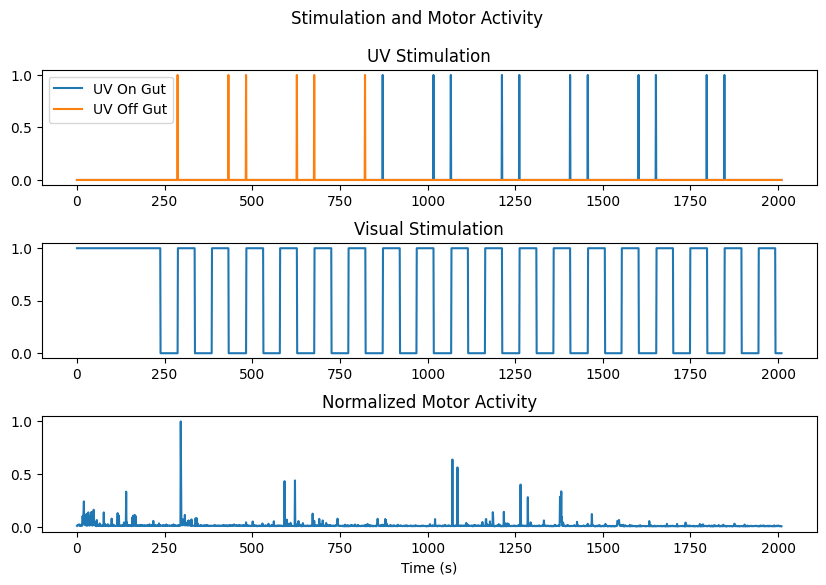

In [9]:
# Plot stimulation and motor activity traces
fig, axs = plt.subplots(3,figsize=(10,6))
plt.subplots_adjust(hspace=.5)
fig.suptitle('Stimulation and Motor Activity')
t= np.arange(0,len(onTrain))/acqFreq
axs[0].plot(t, onTrain,label = "UV On Gut")
axs[0].plot(t, offTrain,label = "UV Off Gut")
axs[0].legend()
axs[0].set_title("UV Stimulation")
axs[1].plot(t,visOpen)
axs[1].set_title("Visual Stimulation")
axs[2].plot(t,sp/np.max(sp))
axs[2].set_title("Normalized Motor Activity")
axs[2].set_xlabel("Time (s)")
plt.show()

In [ ]:
## Run parts model
regMat = np.vstack((onTrain,offTrain+onTrain)) # Regressors for full model
typeVec = [lagOrder_gut,lagOrder_ctrl] # Lag orders for full model
regMat2 = onTrain+offTrain# Regressor for part model
typeVec2=[lagOrder_ctrl] # lag order for part model
## Run regression
mod= fusedLoocv(50,lambdaRidge,lambdaSmooth)
mod.runBothModels(dffTrace,regMat,typeVec,regMat2,typeVec2,uvOnGut)

Running trial 1 of 12


/groups/ahrens/home/jamesb/gutBrainCode/gutBrainPipeline.py:542: RuntimeWarning: invalid value encountered in divide
  c = num/den


Running trial 2 of 12


In [ ]:
# Find threshold for signifanct correlations
thresh = fitLeftGetThresh(np.mean(mod.corr,axis=0),stdThresh)
plt.title("Full Model Correlations")
plt.ylabel("Density")
plt.xlabel("Correlation between true and model")
plt.show()

#fig,ax = plt.figure()
plt.scatter(np.mean(mod.corr,axis=0),np.mean(mod.corr2,axis=0),c='k',s=1)
plt.xlabel("Full Model")
plt.ylabel("Part Model")
xmin, xmax, ymin, ymax= plt.axis()
plt.plot([xmin,xmax],[ymin,ymax],alpha =.5,c='.5')
plt.title("Part vs Full Model Correlations")
plt.show()


In [ ]:
### Pull gut-related cells
firstPass,secondPass,thirdPass,secondPassP,thirdPassP = pullCells(mod,thresh[0],.1,0,50,uvOnGut,uvOffGut[:-1]) # alpha value for comparison control and gut
gutCells = thirdPass
gutDFF = dffTrace[gutCells,:]
print(str(len(gutCells)) + " selected from " + str(len(dffTrace)) + " cells.")

In [ ]:
def meanAndSE(mat,trigs,preTime,postTime):
    trialResponses = np.zeros((len(mat),postTime+preTime,len(trigs)))
    for i in range(0,len(trigs)):
        trialResponses[:,:,i] = mat[:,trigs[i]-preTime:trigs[i]+postTime]
    trialMeans = np.mean(trialResponses,axis=2)
    trialSEs = np.std(trialResponses,axis=2)/np.sqrt(len(trigs))
    return trialResponses, trialMeans, trialSEs

In [ ]:
gutResps, gutMeans,gutSEs = meanAndSE(gutDFF,uvOnGut,10,50)
ctrlResps, ctrlMeans,ctrlSEs = meanAndSE(gutDFF,uvOffGut,10,50)

In [ ]:
plt.imshow(gutDFF,vmin = 0,vmax = 1,aspect = 'auto',cmap = 'gray_r')
plt.axis('off')
plt.plot(onTrain*-100,label = "UV on Gut")
plt.plot(offTrain*-100,label = "UV off Gut")
plt.legend()
plt.title("Gut Cell Raster")
plt.colorbar(label = "DF/F")
plt.xlabel("Time (s)")
plt.ylabel("Gut-responsive Cells")
plt.show()


fig,axs = plt.subplots(3,figsize = (5,5))
fig.suptitle('Mean Response Rasters')
plt.subplots_adjust(hspace=.5)
im = axs[0].imshow(gutMeans,aspect = 'auto',vmin = 0, vmax= 1,cmap = 'gray_r')
axs[1].imshow(ctrlMeans,aspect = 'auto',vmin = 0, vmax= 1,cmap = 'gray_r')
axs[2].imshow(gutMeans-ctrlMeans,aspect = 'auto',vmin = 0, vmax= 1,cmap = 'gray_r') 
fig.colorbar(im,ax=axs[0],label = "DF/F")
fig.colorbar(im,ax=axs[1],label = "DF/F")
fig.colorbar(im,ax=axs[2],label = "DF/F")
axs[0].set_title('Gut Stimulation')
axs[1].set_title("Ctrl Stimulation")
axs[2].set_title("Difference")
plt.show()

grandMean = np.mean(gutMeans,axis=0)
grandSE = np.std(gutMeans,axis=0)/np.sqrt(len(gutMeans))
grandMeanCtrl = np.mean(ctrlMeans,axis=0)
grandSECtrl = np.std(ctrlMeans,axis=0)/np.sqrt(len(ctrlMeans))
xxResp = np.arange(-10,50) /acqFreq
plt.plot(xxResp,grandMean,label = "Gut Responses")
plt.fill_between(xxResp, grandMean-grandSE, grandMean+grandSE,alpha = .5)
plt.plot(xxResp,grandMeanCtrl,label = "Ctrl Responses")
plt.fill_between(xxResp, grandMeanCtrl-grandSECtrl, grandMeanCtrl+grandSECtrl,alpha = .5)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("DF/F")
plt.show()

In [ ]:
# Map selected cells
centers = pullCenters(X[gutCells],Y[gutCells],Z[gutCells])
plt.imshow(brainMap[:,:,:-1].max(axis=2).T, vmin=100,vmax=np.percentile(brainMap[:].squeeze(), 99.98),cmap='gray',aspect = 1)
plt.scatter(centers[:,0],centers[:,1],s=1)
plt.show()
plt.imshow(np.flip(brainMap[:,:,:-1].max(axis=1).T,axis=0), cmap='gray',vmin =100, vmax=np.percentile(brainMap[:].squeeze(), 99.98),interpolation='nearest',aspect= resZ/(resXY*2))
plt.scatter(centers[:,0],brainMap.shape[2]-centers[:,2],s=1)
plt.show()

In [ ]:
from gutBrainCode.gutBrainPipeline import shift, constructLag,makeInputMat,makePsiMat,makeSinglePsiMat, fusedRidge

In [ ]:
## Multiplexing Analysis
# Gut Only
gutReg =  np.vstack((onTrain,offTrain))
gutOrder = [50,50,]
gutBetaHat, gutYHat,gutXMat = fusedRidge(gutDFF,gutReg,gutOrder,lambdaRidge,lambdaSmooth)
gutCorr = corr(gutDFF.T,gutYHat)

# Motor only
motorReg =  sp
motorOrder = [20]
motorDetaHat, motorYHat,motorXMat = fusedRidge(gutDFF,motorReg,motorOrder,lambdaRidge,lambdaSmooth)
motorCorr = corr(gutDFF.T,motorYHat)

# Vis only
visReg =  visOpen
visOrder = [10]
visBetaHat, visYHat,visXMat = fusedRidge(gutDFF,visReg,visOrder,lambdaRidge,lambdaSmooth)
visCorr = corr(gutDFF.T,visYHat)

#GM
gmReg =  np.vstack((onTrain,offTrain,sp))
gmOrder = [50,50,20]
gmBetaHat, gmYHat,gmXMat = fusedRidge(gutDFF,gmReg,gmOrder,lambdaRidge,lambdaSmooth)
gmCorr = corr(gutDFF.T,gmYHat)

#GV
gvReg =  np.vstack((onTrain,offTrain,visOpen))
gvOrder = [50,50,10]
gvBetaHat, gvYHat,gvXMat = fusedRidge(gutDFF,gvReg,gvOrder,lambdaRidge,lambdaSmooth)
gvCorr = corr(gutDFF.T,gvYHat)

#GMV
gmvReg =  np.vstack((onTrain,offTrain,visOpen,sp))
gmvOrder = [50,50,20,1]
gmvBetaHat, gmvYHat,gmvXMat = fusedRidge(gutDFF,gmvReg,gmvOrder,lambdaRidge,lambdaSmooth)
gmvCorr = corr(gutDFF.T,gmvYHat)

In [ ]:
plt.hist(gutCorr,bins = 100,density=True,label = "Pure Gut")
plt.hist(gmvCorr,alpha = .5,bins = 100,density=True,label = "GMV")
plt.legend()
plt.xlabel("Correlation between model and true data")
plt.ylabel("Density")
plt.show()

plt.hist(gmvCorr-gutCorr,bins=100,density=True)
plt.xlabel("Correlation Difference (GMV-G)")
plt.ylabel("Density")
plt.show()


plt.scatter(gutCorr,gmvCorr)
plt.xlabel("Pure Gut Correlation")
plt.ylabel("GMV Correlation")
xmin, xmax, ymin, ymax= plt.axis()
plt.plot([xmin,xmax],[ymin,ymax],alpha =.5,c='.5')
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows= 3,ncols = 3,sharex=True,figsize = (10,10))
axs[0,0].title.set_text('Gut Correlations')
axs[0,0].hist(gutCorr,bins = 100)
axs[0,1].title.set_text('Gut vs Motor')
axs[0,1].scatter(gutCorr,motorCorr)
axs[0,2].title.set_text('Gut vs Vis')
axs[0,2].scatter(gutCorr,visCorr)
axs[1,1].title.set_text('Motor Correlations')
axs[1,1].hist(motorCorr,bins=100)
axs[1,2].title.set_text('Motor vs Vis')
axs[1,2].scatter(motorCorr,visCorr)
axs[2,2].title.set_text('Vis Correlations')
axs[2,2].hist(visCorr,bins=100)
axs[1,0].axis('off')
axs[2,0].axis('off')
axs[2,1].axis('off')
plt.show()